In [131]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

### Carregando a base

In [132]:
headers = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
dataset = pd.read_csv("./iris.data", encoding = "ISO-8859-1", decimal=",", header=None, names=headers)
dataset.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [133]:
for col in  dataset.columns[0:4]:
    dataset[col] = dataset[col].astype(float)

In [134]:
#dataset.groupby(['class'])
#Obtendo as classificações
rotulos = pd.Series(list(dataset["class"])).unique()
rotulos

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [135]:
for x in rotulos:
  print(x)

Iris-setosa
Iris-versicolor
Iris-virginica


In [136]:
#Verificando melhor valor de K utilizando o método Silhouette
def get_best_k_value(base, percent = 0.5, isDebug = False):
    averagesSC = pd.DataFrame(columns=['averageSC', 'k'])
    for i in range(2, int(base.shape[0] * percent)):
        try:
            #visu = SilhouetteVisualizer(KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10))
            #visu = SilhouetteVisualizer(KMeans(n_clusters=i))
            #visu.fit(base)
            #visu.show()   
            kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(base)
            labels = kmeans_model.labels_
            score = metrics.silhouette_score(base, labels, metric='euclidean')
            new_row = {}
            new_row["averageSC"] = score
            new_row["k"] = i
            averagesSC = averagesSC.append(new_row, ignore_index=True)
        except:
          print("Ignorando {value_i}".format(value_i = i))
        finally:
          continue
        
    if isDebug :
        return averagesSC
    else:
        return averagesSC[averagesSC['averageSC'] == averagesSC['averageSC'].max()].iloc[0]['k']
    


In [137]:
for rotulo in rotulos:
    
    subconj = dataset[dataset["class"] == rotulo]
    subconj = subconj.drop(['class'], axis=1)
    
    media = subconj.mean(axis=1) #Média de cada linha
    desvio_padrao = subconj.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
    # Step 1 (2)
    subconj_calc_step_1_2 = subconj.sub(media, axis='index').div(desvio_padrao, axis='index')
    
    # Step 1 (3)
    maior = subconj_calc_step_1_2.max(axis=1) #Maior valor de cada linha
    menor = subconj_calc_step_1_2.min(axis=1) #Menor valor de cada linha
    subconj_calc_step_1_2 = subconj_calc_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
    
    # Verificando melhor valor p/ o k
    k = int(get_best_k_value(base = subconj_calc_step_1_2))
    print("---------------------------------------------------------------------")
    print("Valor de k = {}".format(k))
    # Executando o K-Means
    kmeans = KMeans(n_clusters=k, init="k-means++").fit(subconj_calc_step_1_2)
    informacoes_clustered = kmeans.fit_predict(subconj_calc_step_1_2)    
    results = subconj_calc_step_1_2.copy()
    results['clusterNumber'] = informacoes_clustered
    
    #Step 6 (11)
    print("Step 6 (11)")  
    subrotulos = pd.Series(list(results["clusterNumber"])).unique()
    #print(sorted(subrotulos))
    str_regra = ""
    for subrotulo in sorted(subrotulos):
        count = 1                
        regras = results[results["clusterNumber"] == subrotulo]
        regras = regras.drop(['clusterNumber'], axis=1)
        
        for index, row in regras.iterrows():
            if count == 1:
                str_regra = str_regra + " \n \n Rl: IF (x ~ "
            else:
                str_regra = str_regra +  "   \n  OR (x ~ "
                
            clmn = regras.columns.tolist()
            count_col = 1       
            for nome_coluna in clmn:                
                value = str(row[nome_coluna])
                if count_col != regras.shape[1]:
                    str_regra = str_regra + value + ", "                    
                else:
                    str_regra = str_regra + value + ")"
        
                if count_col == len(clmn) and count == regras.shape[0]:
                    str_regra = str_regra + " THEN (" + rotulo + ")"
                count_col += 1
                
            count += 1
    #print(str_regra)    
    
    
    #B. Hierarchical organisation of the prototypes (13)
    print("\nB. Hierarchical organisation of the prototypes (13) ")  
    #print(sorted(subrotulos))
    str_regra = ""
    count = 1   
    for subrotulo in sorted(subrotulos):                        
            regras = results[results["clusterNumber"] == subrotulo]
            regras = regras.drop(['clusterNumber'], axis=1)
            
            #B. Hierarchical organisation of the prototypes (13) primeiro fazendo o cálculo de pj/P
            regras = regras/regras.shape[0]
            #B. Hierarchical organisation of the prototypes (13) aplicando o somatório e gerando a regra consolidada
            regras = regras.sum(axis=0).to_frame().transpose()
            if count == 1:
                str_regra = str_regra + " \n Rl: IF (x ~ "
            else:
                str_regra = str_regra +  "   \n  OR (x ~ "
                
            for index, row in regras.iterrows():                                  
                clmn = regras.columns.tolist()
                count_col = 1       
                for nome_coluna in clmn:                
                    value = str(round(row[nome_coluna], 6))
                    if count_col != regras.shape[1]:
                        str_regra = str_regra + value + ", "                    
                    else:
                        str_regra = str_regra + value + ")"
            
                    if count_col == len(clmn) and count == len(subrotulos):
                        str_regra = str_regra + " THEN (" + rotulo + ")"
                    count_col += 1
                    
            count += 1
    print(str_regra) 


---------------------------------------------------------------------
Valor de k = 8
Step 6 (11)

B. Hierarchical organisation of the prototypes (13) 
 
 Rl: IF (x ~ 1.0, 0.660953, 0.25262, 0.0)   
  OR (x ~ 1.0, 0.766619, 0.222573, 0.0)   
  OR (x ~ 1.0, 0.695344, 0.326043, 0.0)   
  OR (x ~ 1.0, 0.60868, 0.232752, 0.0)   
  OR (x ~ 1.0, 0.47619, 0.238095, 0.0)   
  OR (x ~ 1.0, 0.709588, 0.254497, 0.0)   
  OR (x ~ 1.0, 0.686474, 0.190446, 0.0)   
  OR (x ~ 1.0, 0.624791, 0.290805, 0.0) THEN (Iris-setosa)
---------------------------------------------------------------------
Valor de k = 6
Step 6 (11)

B. Hierarchical organisation of the prototypes (13) 
 
 Rl: IF (x ~ 1.0, 0.331763, 0.739497, 0.0)   
  OR (x ~ 1.0, 0.32232, 0.594607, 0.0)   
  OR (x ~ 1.0, 0.272529, 0.632083, 0.0)   
  OR (x ~ 1.0, 0.185757, 0.655544, 0.0)   
  OR (x ~ 1.0, 0.363297, 0.659095, 0.0)   
  OR (x ~ 1.0, 0.354173, 0.513933, 0.0) THEN (Iris-versicolor)
------------------------------------------------------

# Density-Based Input Selection

In [138]:
conj = dataset.drop(['class'], axis=1)   
conj

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [139]:
media = conj.mean(axis=1) #Média de cada linha
media

0      2.550
1      2.375
2      2.350
3      2.350
4      2.550
       ...  
145    4.300
146    3.925
147    4.175
148    4.325
149    3.950
Length: 150, dtype: float64

In [140]:
desvio_padrao = conj.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
desvio_padrao

0      1.887459
1      1.764051
2      1.729884
3      1.656050
4      1.867485
         ...   
145    1.750714
146    1.797742
147    1.772533
148    1.551411
149    1.631717
Length: 150, dtype: float64

In [141]:
# Step 1 (2)
conj_calc_step_1_2 = conj.sub(media, axis='index').div(desvio_padrao, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.351023,0.503322,-0.609285,-1.245060
1,1.431365,0.354298,-0.552705,-1.232958
2,1.358472,0.491362,-0.606977,-1.242858
3,1.358655,0.452885,-0.513270,-1.298270
4,1.311925,0.562254,-0.615801,-1.258377
...,...,...,...,...
145,1.370869,-0.742554,0.514076,-1.142391
146,1.321102,-0.792661,0.597972,-1.126413
147,1.311682,-0.662893,0.578268,-1.227057
148,1.208577,-0.596232,0.692918,-1.305264


In [142]:
# Step 1 (3)
maior = conj_calc_step_1_2.max(axis=1) #Maior valor de cada linha
menor = conj_calc_step_1_2.min(axis=1) #Menor valor de cada linha
conj_calc_step_1_2 = conj_calc_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
...,...,...,...,...
145,1.0,0.159091,0.659091,0.0
146,1.0,0.136364,0.704545,0.0
147,1.0,0.222222,0.711111,0.0
148,1.0,0.282051,0.794872,0.0


In [143]:
media = conj_calc_step_1_2.mean(axis=1) #Média de cada linha
media

0      0.479592
1      0.462766
2      0.477778
3      0.488636
4      0.489583
         ...   
145    0.454545
146    0.460227
147    0.483333
148    0.519231
149    0.524390
Length: 150, dtype: float64

In [144]:
desvio_padrao = conj_calc_step_1_2.std(ddof=0, axis=1) #Desvio padrão, da população N (ddof=0), de cada linha
desvio_padrao

0      0.385196
1      0.375330
2      0.384419
3      0.376375
4      0.389059
         ...   
145    0.397890
146    0.408578
147    0.393896
148    0.397798
149    0.397980
Length: 150, dtype: float64

# C. Density-Based Input Selection (14)

In [145]:
#C. Density-Based Input Selection (14)
#=1/(1 + (POTÊNCIA(RAIZ(POTÊNCIA(C4-H4;2));2)/POTÊNCIA(I4;2)))
conj_calc_step_1_2 = conj_calc_step_1_2.sub(media, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.520408,0.193878,-0.234694,-0.479592
1,0.537234,0.132979,-0.207447,-0.462766
2,0.522222,0.188889,-0.233333,-0.477778
3,0.511364,0.170455,-0.193182,-0.488636
4,0.510417,0.218750,-0.239583,-0.489583
...,...,...,...,...
145,0.545455,-0.295455,0.204545,-0.454545
146,0.539773,-0.323864,0.244318,-0.460227
147,0.516667,-0.261111,0.227778,-0.483333
148,0.480769,-0.237179,0.275641,-0.519231


In [146]:
conj_calc_step_1_2 = conj_calc_step_1_2.pow(2, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.270825,0.037589,0.055081,0.230008
1,0.288620,0.017683,0.043034,0.214152
2,0.272716,0.035679,0.054444,0.228272
3,0.261493,0.029055,0.037319,0.238765
4,0.260525,0.047852,0.057400,0.239692
...,...,...,...,...
145,0.297521,0.087293,0.041839,0.206612
146,0.291355,0.104888,0.059691,0.211809
147,0.266944,0.068179,0.051883,0.233611
148,0.231139,0.056254,0.075978,0.269601


In [147]:
conj_calc_step_1_2 = conj_calc_step_1_2 ** (1/2)
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.520408,0.193878,0.234694,0.479592
1,0.537234,0.132979,0.207447,0.462766
2,0.522222,0.188889,0.233333,0.477778
3,0.511364,0.170455,0.193182,0.488636
4,0.510417,0.218750,0.239583,0.489583
...,...,...,...,...
145,0.545455,0.295455,0.204545,0.454545
146,0.539773,0.323864,0.244318,0.460227
147,0.516667,0.261111,0.227778,0.483333
148,0.480769,0.237179,0.275641,0.519231


In [148]:
conj_calc_step_1_2 = conj_calc_step_1_2.pow(2, axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.270825,0.037589,0.055081,0.230008
1,0.288620,0.017683,0.043034,0.214152
2,0.272716,0.035679,0.054444,0.228272
3,0.261493,0.029055,0.037319,0.238765
4,0.260525,0.047852,0.057400,0.239692
...,...,...,...,...
145,0.297521,0.087293,0.041839,0.206612
146,0.291355,0.104888,0.059691,0.211809
147,0.266944,0.068179,0.051883,0.233611
148,0.231139,0.056254,0.075978,0.269601


In [149]:
conj_calc_step_1_2 = conj_calc_step_1_2.div(desvio_padrao.pow(2, axis='index'), axis='index')
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,1.825263,0.253333,0.371228,1.550175
1,2.048805,0.125527,0.305483,1.520185
2,1.845447,0.241437,0.368421,1.544695
3,1.845943,0.205105,0.263446,1.685506
4,1.721147,0.316129,0.379211,1.583513
...,...,...,...,...
145,1.879282,0.551387,0.264274,1.305057
146,1.745310,0.628312,0.357571,1.268807
147,1.720509,0.439427,0.334394,1.505669
148,1.460660,0.355492,0.480135,1.703713


In [150]:
conj_calc_step_1_2 = 1/(conj_calc_step_1_2 + 1)
conj_calc_step_1_2

,sepal length,sepal width,petal length,petal width
0,0.353949,0.797872,0.729273,0.392130
1,0.327997,0.888473,0.766000,0.396796
2,0.351439,0.805518,0.730769,0.392974
3,0.351377,0.829803,0.791486,0.372369
4,0.367492,0.759804,0.725052,0.387070
...,...,...,...,...
145,0.347309,0.644585,0.790968,0.433829
146,0.364258,0.614133,0.736610,0.440760
147,0.367578,0.694721,0.749404,0.399095
148,0.406395,0.737739,0.675614,0.369862


# C. Density-Based Input Selection (15)

In [151]:
#C. Density-Based Input Selection (15)
conj_calc_step_1_2 = conj_calc_step_1_2.sum(axis=0)
conj_calc_step_1_2

sepal length     54.808481
sepal width     115.128602
petal length    114.459094
petal width      58.118992
dtype: float64

In [152]:
conj_calc_step_1_2.to_frame()#.transpose()

,0
sepal length,54.808481
sepal width,115.128602
petal length,114.459094
petal width,58.118992


-----------------------------

# Rascunho ...

- SC ≤ 0,25 → Nenhuma estrutura relevante encontrada
- 0,26 ≤ SC ≤ 0,5 → Estrutura fraca/artificial
- 0,51 ≤ SC ≤ 0,7 → Estrutura razoável
- 0,71 ≤ SC ≤ 1 → Estrutura forte

In [153]:
#Test
df = dataset[dataset["class"] == "Iris-setosa"]
df = df.drop(['class'], axis=1)
media = df.mean(axis=1)
desvio = df.std(ddof=0, axis=1)

calculado_step_1_2 = df.sub(media, axis='index').div(desvio, axis='index')

maior = calculado_step_1_2.max(axis=1)
menor = calculado_step_1_2.min(axis=1)

calculado_step_1_3 = calculado_step_1_2.sub(menor, axis='index').div(maior.sub(menor, axis='index'), axis='index')
calculado_step_1_3


#visualizer = KElbowVisualizer(KMeans(init="k-means++", max_iter=300, n_init=10), k=(2,15)) #init="k-means++"

#visualizer.fit(calculado_step_1_3)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure




,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
5,1.0,0.700000,0.260000,0.0
6,1.0,0.720930,0.255814,0.0
7,1.0,0.666667,0.270833,0.0
8,1.0,0.642857,0.285714,0.0
9,1.0,0.625000,0.291667,0.0


In [154]:
calculado_step_1_3.shape[0]
calculado_step_1_3.sum(axis=0).to_frame().transpose()

,sepal length,sepal width,petal length,petal width
0,50.0,33.298294,12.844805,0.0


In [155]:
calculado_step_1_3

,sepal length,sepal width,petal length,petal width
0,1.0,0.673469,0.244898,0.0
1,1.0,0.595745,0.255319,0.0
2,1.0,0.666667,0.244444,0.0
3,1.0,0.659091,0.295455,0.0
4,1.0,0.708333,0.250000,0.0
5,1.0,0.700000,0.260000,0.0
6,1.0,0.720930,0.255814,0.0
7,1.0,0.666667,0.270833,0.0
8,1.0,0.642857,0.285714,0.0
9,1.0,0.625000,0.291667,0.0


In [156]:
#Test 
#averagesSC = 
averagesSC = get_best_k_value(base = calculado_step_1_3, isDebug = True)
averagesSC[averagesSC['averageSC'] == averagesSC['averageSC'].max()]


,averageSC,k
7,0.399909,9.0


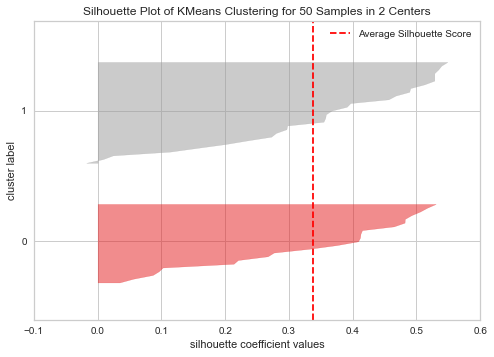

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 50 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [157]:
visu = SilhouetteVisualizer(KMeans(2))
visu.fit(calculado_step_1_3)
visu.show()